In [1]:
import os
import imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from skimage.filters import frangi


2022-09-14 15:14:57,094-[INFO]- numexpr.utils:145 -> Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-09-14 15:14:57,094-[INFO]- numexpr.utils:157 -> NumExpr defaulting to 8 threads.


/home/ipausers/bisot/pycode/MscThesis/amftrack/util/dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
images_path = r"/mnt/sun/home-folder/bisot/Video05_04x"
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path,file) for file in files]
images_total_path.sort()

In [3]:
def frame_num(file):
    return(int(file.split('_')[-1].split('.')[0]))
def movie_num(file):
    return(file.split('_')[-2])

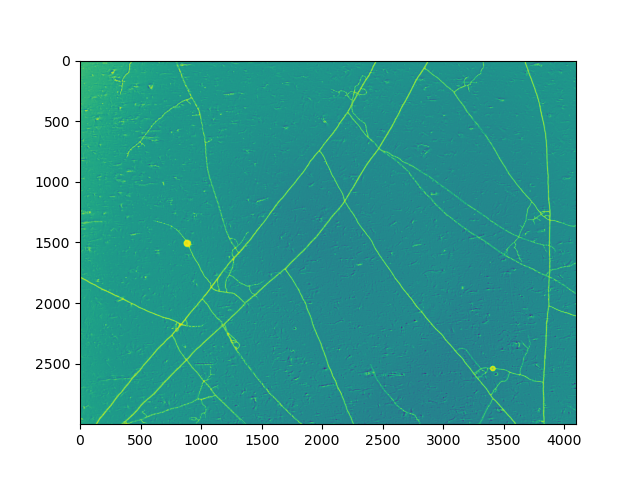

In [4]:
range_interest = range(0,10000)
selection_file = [file for file in images_total_path if frame_num(file) in range_interest]
# selection_file = [file for file in selection_file if movie_num(file)=='150115688']
selection_file.sort()
image = imageio.imread(selection_file[-1])
fig, ax = plt.subplots()
ax.imshow(-image)

In [77]:
# images_adress = selection_file[:10]
# images = [imageio.imread(file) for file in images_adress]
# images = [cv2.resize(image, np.flip(images[0].shape)) for image in images]
# average_proj = np.mean(np.array(images),axis=0)
# frangised = frangi(average_proj, sigmas=range(5, 20, 4)) * 255
segmented = frangised>120
segmented = remove_holes(segmented)
segmented = segmented.astype(np.uint8)
connected = remove_component(segmented)
connected = connected.astype(np.uint8)
skeletonized = cv2.ximgproc.thinning(np.array(connected, dtype=np.uint8))
skeleton = scipy.sparse.dok_matrix(skeletonized)
nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
nx_graph, pos = remove_spurs(nx_graph, pos,threshold = 20)
nx_graph_pruned = nx_graph

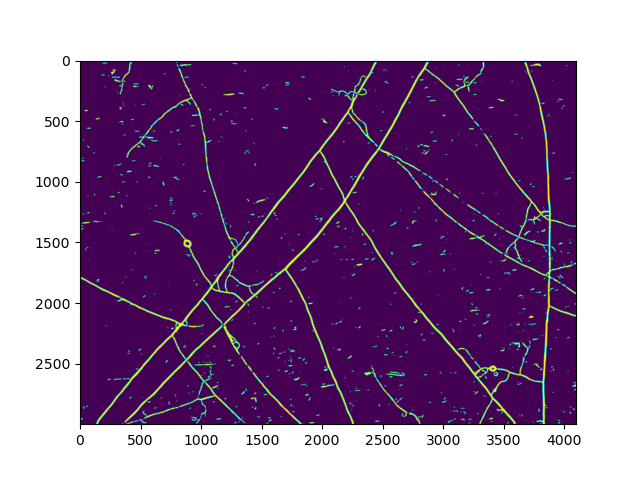

In [76]:
fig, ax = plt.subplots()
ax.imshow(segmented)

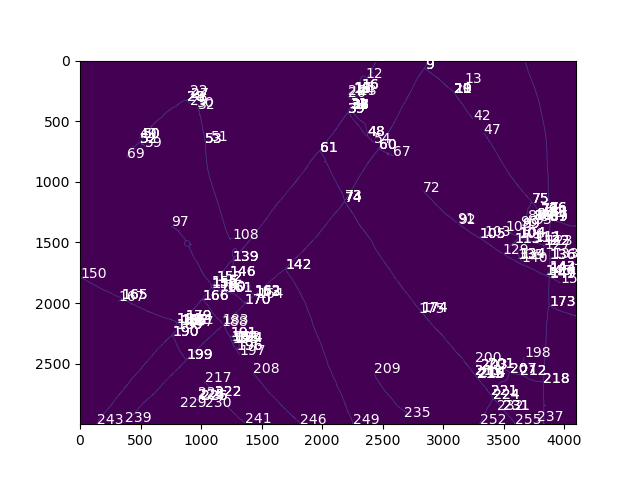

In [79]:
fig, ax = plt.subplots()
ax.imshow(skeletonized)
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip(pos[edge[0]]),str(edge[0]),color="white")
    ax.text(*np.flip(pos[edge[1]]),str(edge[1]),color="white")

In [80]:
edges = [(142,74)]

In [8]:
# edges = [(109,56),(50,33),(83,48),(74,59),(241,219),(185,151),(48,35),(48,16),(59,1)]

In [81]:
slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=1,
    offset=4,
    step=15,
    target_length=10,
)

Text(0.5, 1.0, 'Slices taken along one hypha')

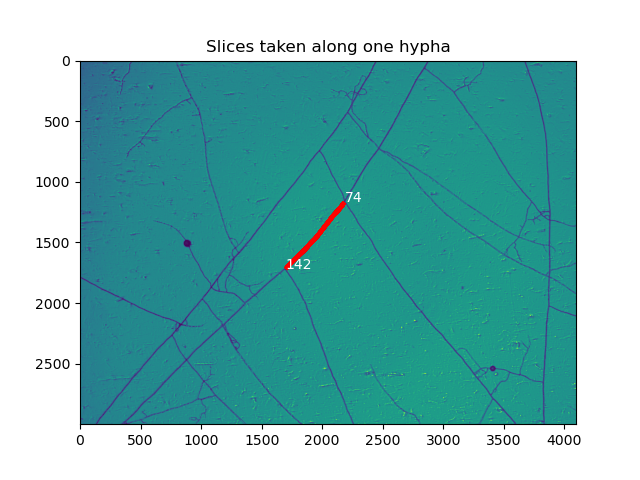

In [84]:
plt.close("all")
fig, ax = plt.subplots()
ax.imshow(image)
for edge in edges:
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=1,
    offset=4,
    step=15,
    target_length=10,
)
    plot_segments_on_image(segments,ax)
    ax.text(*np.flip(pos[edge[0]]),str(edge[0]),color="white")
    ax.text(*np.flip(pos[edge[1]]),str(edge[1]),color="white")
plt.title("Slices taken along one hypha")

In [85]:
kymos = {edge:get_kymo(edge,pos,selection_file,nx_graph_pruned) for edge in edges}

In [86]:
filtered_kymos = {edge: filter_kymo(kymos[edge]) for edge in edges}
speeds = {}

In [92]:
W = 30          # window size is WxW
time_pixel_size = 0.10 #s.pixel
space_pixel_size = 1.725*2 #um.pixel
speeds = {}
for edge in edges:
    imgCoherency, imgOrientation = calcGST(filtered_kymos[edge][0], W)
    speeds[edge]=np.tan((imgOrientation-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
    speeds[edge]=speeds[edge]


In [88]:
import math
def gridplot(
    n: int,
    ncols = None,
    subw: float = 4.0,
    subh: float = 4.0,
    **kwargs,
):
    if ncols is None:
        ncols = n
    nrows = math.ceil(n / ncols)
    figsize = (subw * ncols, subh * nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    return fig, iter(axs.flatten())

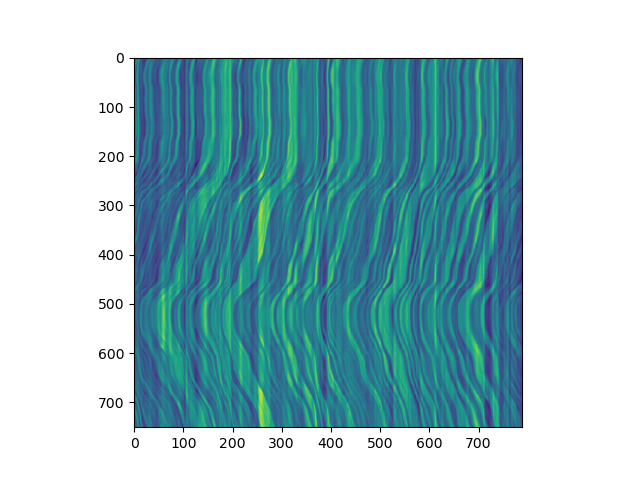

In [89]:
fig,ax = plt.subplots()
ax.imshow(kymos[edges[0]])


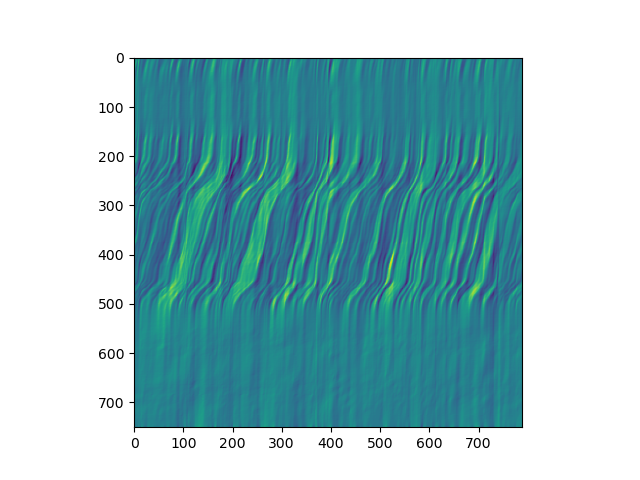

In [90]:
fig,ax = plt.subplots()
ax.imshow(filtered_kymos[edges[0]][0])


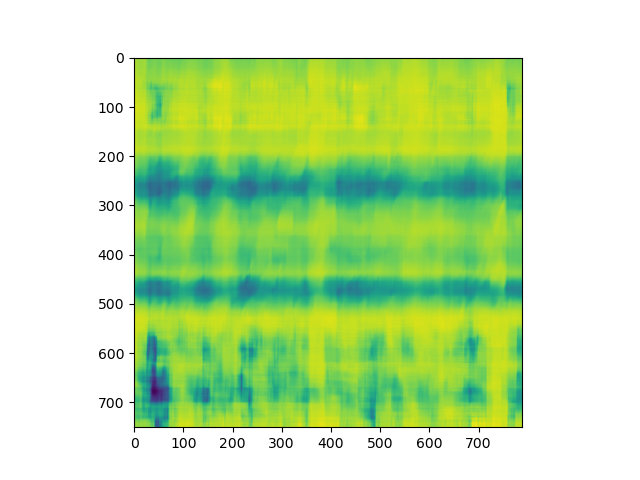

In [93]:
fig,ax = plt.subplots()
ax.imshow(imgOrientation)